In [24]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

try:
  from zoltpy import util, connection
except:
  !pip install pymmwr
  !pip install git+https://github.com/reichlab/zoltpy/
  from zoltpy import util, connection

try:
  from qenspy import qens
except:
  !pip install git+https://github.com/reichlab/qenspy@params
  from qenspy import qens

from numpy.core.arrayprint import format_float_positional
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Download example forecast data from Zoltar
os.environ["Z_USERNAME"] = "zoltar_demo"
os.environ["Z_PASSWORD"] = "Dq65&aP0nIlG"
conn = util.authenticate()
project_name = 'COVID-19 Forecasts'

In [3]:
def query_project_forecasts_and_truth(conn, project_name, models, units, targets, timezeros, types):
  """Query forecasts and corresponding observed truth from Zoltar."""
  query = {
    "models": models,
    "units": units,
    "targets": targets,
    "timezeros": timezeros,
    "types": types}
  forecasts = util.query_project(conn, project_name, connection.QueryType.FORECASTS, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['model', 'unit', 'forecast_date', 'target', 'quantile', 'value']]
  
  query = {
    "units": units,
    "targets": targets,
    "timezeros": timezeros}
  truth = util.query_project(conn, project_name, connection.QueryType.TRUTH, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['unit', 'forecast_date', 'target', 'value']]
  
  return (forecasts, truth.drop_duplicates())

In [4]:
def q_df_to_array(q_df, tau_strs, models):
  """Convert predictive quantiles from a tidy data frame to a 3d array."""
  q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
  model_cols = q_wide.columns.get_level_values(1)
    
  def model_q_ordered(model):
    #print(model)
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    missing_cols = np.setdiff1d(tau_strs, df_one_model.columns.values)
    for col_name in missing_cols:
      df_one_model[col_name] = np.NaN
    #print(df_one_model)
    return df_one_model[tau_strs].values
    
  q_arr = np.concatenate(
    [model_q_ordered(model)[..., np.newaxis] for model in models],
    axis = 2
  )
  
  return q_arr

In [5]:
def plot_forecasts(
  q,
  y,
  models,
  tau):
  """Plot observations and predictions."""
  ncols = 3
  nrows = (len(models) + 1)//ncols
  print("nrows = " + str(nrows))
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
  fig.set_tight_layout(True)
  
  interval_colors = ['#a6bddb', '#74a9cf', '#3690c0', '#0570b0']
  interval_labels = ['98%', '95%', '80%', '50%']
  
  for m in range(len(models)):
    row_ind = m // ncols
    col_ind = m % ncols
    
    ax[row_ind, col_ind].grid()
    ax[row_ind, col_ind].set_axisbelow(True)
    ax[row_ind, col_ind].set(
      xticks=np.linspace(1, 4, 4),
      xlabel='Forecast Horizon',
      ylabel='',
      title=models[m])
    #ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.StrMethodFormatter('{:s}')) #%8d
    ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.FormatStrFormatter('%8d')) #
    #ax[row_ind, col_ind].text(0,1,models[m],ha='right',va='top',transform=ax[row_ind, col_ind].transAxes,weight='bold')
    
    # Prediction intervals
    for interval_ind, half_alpha in enumerate([0.01, 0.025, 0.1, 0.25]):
      k_lower = np.where(abs(tau - half_alpha) < 1e-7)
      k_upper = np.where(abs(tau - (1 - half_alpha)) < 1e-7)
      ax[row_ind, col_ind].fill_between(
        np.linspace(1, 4, 4),
        q[:, k_lower, m].reshape(4),
        q[:, k_upper, m].reshape(4),
        color = interval_colors[interval_ind],
        label = interval_labels[interval_ind])
    
    # train set data
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        y,
        'orange',
        label = "Observed")
    
    # plot predictive median
    k_median = np.where(abs(tau - 0.5) < 1e-7)
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        q[:, k_median, m].reshape(4),
        '#034e7b',
        ls='--',
        lw=3.0,
        label = "Forecast")
    
    if m == 0:
      ax[row_ind, col_ind].legend(loc='upper right', ncol=3)
  
  plt.show()

In [6]:
# load forecasts and data from Zoltar
models = ["epiforecasts-ensemble1", "LNQ-ens1", "UMass-MechBayes"]
models = ['AIpert-pwllnod', 'BPagano-RtDriven', 'CEID-Walk', 'CMU-TimeSeries', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'COVIDhub-baseline', 'CU-select', 'epiforecasts-ensemble1', 'Geneva-DetGrowth', 'Google_Harvard-CPF', 'IHME-CurveFit', 'IowaStateLW-STEM', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'JHUAPL-Bucky', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'Microsoft-DeepSTIA', 'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'OliverWyman-Navigator', 'PSI-DRAFT', 'RobertWalraven-ESG', 'RPI_UW-Mob_Collision', 'SigSci-TS', 'TTU-squider', 'UA-EpiCovDA', 'UCSD_NEU-DeepGLEAM', 'UMass-MechBayes', 'UMich-RidgeTfReg', 'USC-SI_kJalpha']
train_units = ['US', '01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '60', '66', '69', '72', '74', '78']
test_units = ["39"]
targets = [str(h + 1) + ' wk ahead inc death' for h in range(4)]
types = ["quantile"]
train_timezeros = [
  '2021-01-03', '2021-01-04', '2021-01-10', '2021-01-11',
  '2021-01-17', '2021-01-18', '2021-01-24', '2021-01-25',
  '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-08']
test_timezeros = ['2021-02-14', '2021-02-15']

In [7]:
tau_strs = ['0.01', '0.025']
tau_strs.extend(
  [np.format_float_positional(x, 2) for x in np.linspace(0.05, 0.95, 19)])
tau_strs.extend(['0.975', '0.99'])
tau = tf.constant(np.array(tau_strs).astype('float64'))


In [8]:
(train_forecasts, train_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=train_units,
  targets=targets,
  timezeros=train_timezeros,
  types=types)


* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/54322/', 54322)
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/54323/', 54323)
- QUEUED
- QUEUED
- QUEUED
- QUEUED
- SUCCESS


In [12]:
(test_forecasts, test_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=test_units,
  targets=targets,
  timezeros=test_timezeros,
  types=types)



* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/54330/', 54330)
- QUEUED
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/54331/', 54331)
- QUEUED
- SUCCESS


In [13]:
q_train = tf.constant(q_df_to_array(train_forecasts, tau_strs, models))
y_train = tf.constant(train_truth['value'].values)

q_test = tf.constant(q_df_to_array(test_forecasts, tau_strs, models))
y_test = tf.constant(test_truth['value'].values)

In [14]:
q_train[:, :, 17]

<tf.Tensor: shape=(1368, 23), dtype=float64, numpy=
array([[  170. ,   184. ,   200.8, ...,   511. ,   557. ,   588. ],
       [  167. ,   185. ,   203. , ...,   608. ,   687. ,   723. ],
       [  157. ,   187.9,   209. , ...,   724.1,   790.3,   870. ],
       ...,
       [11571.9, 11990.2, 12446.6, ..., 17388.9, 18110.5, 18782.2],
       [ 9271.1,  9743.6, 10215.6, ..., 15063.9, 15888.1, 16438.6],
       [ 7483.2,  7909.3,  8294.8, ..., 12919.9, 13702.9, 14330. ]])>

In [15]:
q_df = train_forecasts

"""Convert predictive quantiles from a tidy data frame to a 3d array."""
q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
model_cols = q_wide.columns.get_level_values(1)
    
def model_q_ordered(model):
    #print(model)
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    missing_cols = np.setdiff1d(tau_strs, df_one_model.columns.values)
    for col_name in missing_cols:
        df_one_model[col_name] = np.NaN
    #print(df_one_model)
    return df_one_model[tau_strs].values

# q_arr = np.concatenate(
#     [model_q_ordered(model)[..., np.newaxis] for model in models],
#     axis = 2
# )
model_q_ordered('Karlen-pypm')[..., np.newaxis].shape

(1368, 23, 1)

In [16]:
# illustrate calculation of equal-weighted mean ensemble
K = len(tau)
M = len(models)

w_equal = tf.constant(np.full((K, M), 1./M))
q_equal_mean = qens.MeanQEns().predict(q_test, w={'w': w_equal})

In [22]:
# fit a weighted mean ensemble
tau_groups = np.zeros(len(tau))
init_param_vec = tf.constant(np.zeros(34))

meanqens = qens.MeanQEns()
meanqens.fit(y_train, q_train, tau, tau_groups, init_param_vec = init_param_vec, optim_method="sgd", num_iter=10000, learning_rate=0.1, verbose = True)

 1.21100308e-04,
       -1.92453012e-03,  1.29361216e-04,  1.33548392e-04,  1.12103656e-04,
        9.54687265e-05,  8.87645455e-05,  1.92102812e-04,  1.04917568e-04,
        1.02045852e-04,  6.99522962e-05, -1.72900187e-04,  1.07973764e-04,
        1.32449332e-04,  2.00936722e-23,  1.19694756e-04,  1.03588430e-04,
        2.02707042e-04,  8.76372087e-05])>]
9985
param estimates vec = 
[-6.78933288e-01 -9.37154841e-01 -1.13063484e+00 -1.02412043e+00
 -1.90898973e+00 -1.58925298e+00  6.72175701e+00 -1.60232696e+00
 -1.90538253e-01 -4.43971460e-01  9.15355649e-17  9.15355649e-17
  9.15355649e-17 -2.07106984e+00 -8.58801226e-01 -9.96683776e-01
  1.99210257e+01 -8.06045932e-01 -1.55250187e+00  6.57139720e-01
 -2.20097502e+00 -2.12452533e+00 -3.73603356e-01 -1.61999073e+00
 -1.85313595e+00 -1.31093815e+00  9.81061535e+00 -2.29149520e+00
 -5.57399466e-01  9.15355649e-17 -1.29017696e+00 -1.63993474e+00
 -2.54896626e-01 -2.23494625e+00]
loss = 
447.38711911696777
grads = 
[<tf.Tensor: shape=(3

In [23]:
# illustrate calculation of unequal-weighted mean ensemble predictions
q_weighted_mean = meanqens.predict(q_test)

In [25]:
q_model16 = q_train[:, :, 16]
to_keep16 = (np.sum(np.isnan(q_model16.numpy()), axis = 1) == 0)
q_model17 = q_train[:, :, 17]
to_keep17 = (np.sum(np.isnan(q_model17.numpy()), axis = 1) == 0)
to_keep = np.logical_and(to_keep16, to_keep17)

q_model16 = tf.constant(q_model16.numpy()[to_keep, :])
q_model17 = tf.constant(q_model17.numpy()[to_keep, :])

In [26]:
meanqens.pinball_loss(y_train[to_keep], q_model16, tau)

<tf.Tensor: shape=(), dtype=float64, numpy=475.5658490618104>

In [27]:
meanqens.pinball_loss(y_train[to_keep], q_model17, tau)

<tf.Tensor: shape=(), dtype=float64, numpy=515.1056842493847>

In [30]:
q_model17.shape

TensorShape([1060, 23])

In [36]:
import tensorflow_addons as tfa

In [90]:
np.mean([tfa.losses.pinball_loss(y_train[to_keep], q_model17[:, k], tau[k]).numpy() for k in range(23)])

518.5237728465955

In [37]:
# fit a weighted mean ensemble
tau_groups = np.zeros(len(tau))
init_param_vec = tf.constant(np.zeros(34))

medianqens = qens.MedianQEns(bw_method="silverman_weighted")
medianqens.fit(y_train, q_train, tau, tau_groups, init_param_vec = init_param_vec, optim_method="adam", num_iter=100, learning_rate=0.1, verbose = True)

1409578e-03,  1.07353469e-02,  1.69429921e-02,
       -2.07950037e+00,  3.79323625e-02,  3.33665492e-02, -5.79975876e-04,
        8.90086429e-03,  8.27301527e-03, -5.01606002e-01,  6.11039873e-03,
        6.05326409e-03, -3.38212731e-04, -1.76617641e-03,  4.29829153e-03,
        8.56921639e-03,  7.56454151e-18,  8.72906464e-03,  5.07185305e-03,
       -5.12927347e-01,  7.90520018e-03])>]
85
param estimates vec = 
[-2.46307085e+00 -6.08442192e-01 -2.38332285e+00 -1.78991024e+00
 -1.76964729e+00 -2.67253145e+00  4.29929093e+00 -1.47625493e+00
  1.15147042e+00  4.52188889e-01 -3.86897195e-11 -3.86897195e-11
 -3.86897195e-11 -2.51707782e+00 -1.97256905e+00 -1.16212472e+00
  4.82779227e+00 -8.83253390e-01 -8.83148959e-01  1.69656699e+00
 -2.52688510e+00 -2.52355288e+00  2.49459969e+00 -2.88983986e+00
 -2.77158114e+00 -1.82727090e+00 -1.74622417e+00 -2.55403133e+00
  1.65433799e-01 -3.86897195e-11 -1.19256364e+00 -2.75793150e+00
  4.23421848e+00 -2.48922601e+00]
loss = 
458.26471791263094
gr

In [39]:
# illustrate calculation of unequal-weighted mean ensemble predictions
q_weighted_median = medianqens.predict(q_test)

nrows = 13
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


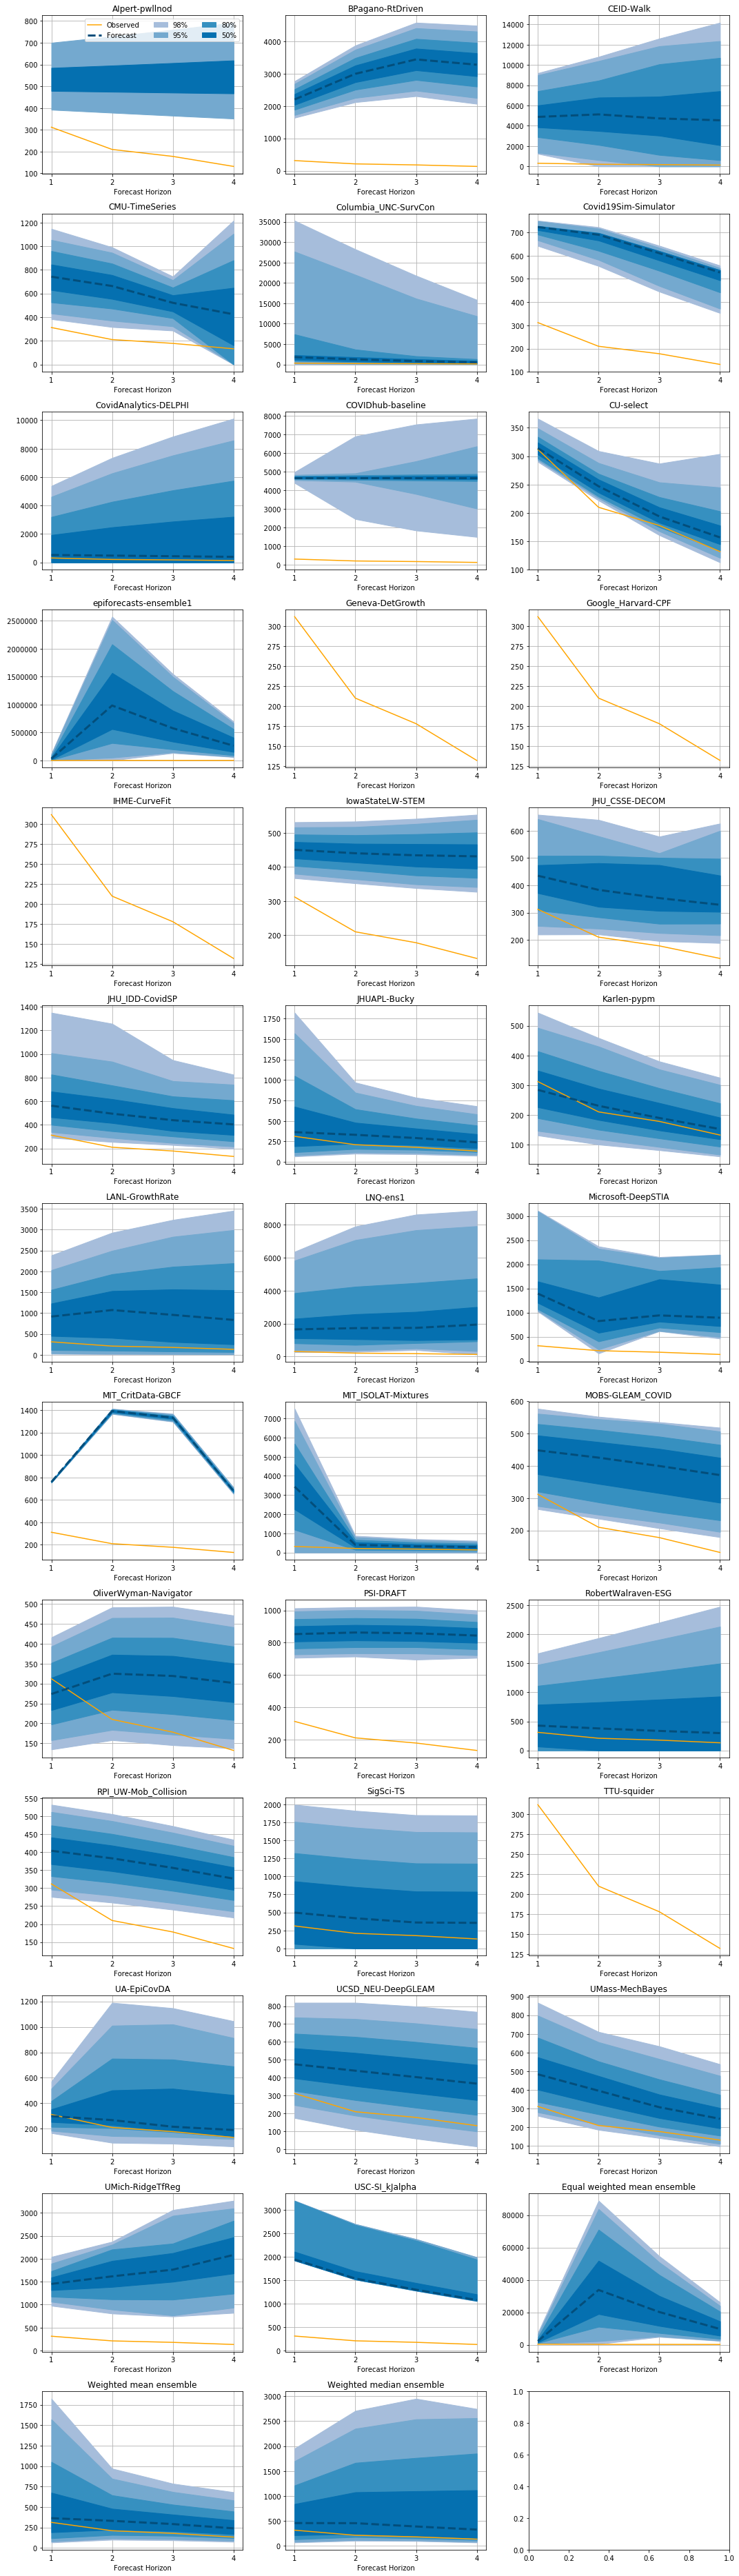

In [40]:
# make a plot
q_combined = np.concatenate([q_test, q_equal_mean[..., np.newaxis], q_weighted_mean[..., np.newaxis], q_weighted_median[..., np.newaxis]], axis = 2)
models_combined = models.copy()
models_combined.append('Equal weighted mean ensemble')
models_combined.append('Weighted mean ensemble')
models_combined.append('Weighted median ensemble')

plot_forecasts(
  q = q_combined,
  y = y_test,
  models = models_combined,
  tau = tau)